In [1]:
import pandas as pd
import plotly.express as px

model = "deepseek_reasoner"

predictions = pd.read_parquet(f"output/predictions_{model}.parquet")
predictions["ground_truth"] = predictions["ground_truth"] == "Annahme"
predictions["prediction"] = predictions["prediction"] == "Annahme"
predictions["vote_correct"] = predictions["prediction"] == predictions["ground_truth"]
predictions = predictions[predictions["ground_truth"].notna()]
predictions.drop_duplicates(subset=["vote_id", "drucksache_id", "party"], inplace=True)

category_mapping = {
    "Finanzen - Steuern, Staatsbudget, Haushalts- und Finanzpolitik": "Finance",
    "Inneres & Migration - Innere Sicherheit, öffentliche Verwaltung, Migration, Staatsbürgerschaft": "Internal Affairs & Migration",
    "Außenpolitik & Europäische Angelegenheiten - Diplomatie, internationale Beziehungen, EU-Politik": "Foreign Policy & European Affairs",
    "Verteidigung & Sicherheit - Militär, Verteidigungsstrategie, Bundeswehr, Rüstung": "Defense & Security",
    "Wirtschaft & Energie - Industriepolitik, Mittelstand, Energieversorgung, Wirtschaftsordnungen": "Economy & Energy",
    "Forschung & Technologie - Innovationsförderung, Raumfahrt, Forschungseinrichtungen, Technologietransfer": "Research & Technology",
    "Justiz & Verbraucherschutz - Rechtsprechung, Gesetzgebung, Verbraucherschutz, Datenschutz": "Justice & Consumer Protection",
    "Bildung, Familie & Jugend - Schulen, Hochschulen, Familienförderung, Kinder- und Jugendpolitik": "Education, Family & Youth",
    "Arbeit & Soziales - Arbeitsmarktpolitik, Sozialversicherung, Renten, Integration": "Labor & Social Affairs",
    "Digitalisierung & Modernisierung - E-Government, IT-Infrastruktur, digitale Verwaltung, Cybersecurity": "Digitalization & Modernization",
    "Verkehr & Infrastruktur - Straßen-, Schienen- und Luftverkehr, Mobilitätskonzepte, Infrastrukturprojekte": "Transport & Infrastructure",
    "Umwelt, Klima & Naturschutz - Umweltschutz, Klimapläne, Artenschutz, nukleare Sicherheit": "Environment, Climate & Nature Conservation",
    "Gesundheit - Gesundheitssystem, Krankenversicherung, Arzneimittelregulierung, Pandemie- und Präventionspolitik": "Health",
    "Landwirtschaft & Ernährung - Agrarpolitik, Ernährungssicherheit, Ländliche Entwicklung": "Agriculture & Food",
    "Entwicklungszusammenarbeit - Entwicklungsprojekte, humanitäre Hilfe, internationale Zusammenarbeit": "Development Cooperation",
    "Wohnen & Stadtentwicklung - Wohnungsbau, Städtebau, Bauordnung, Städtebauförderung": "Housing & Urban Development",
}

predictions["category"] = predictions["category"].replace(category_mapping)
predictions.query("type == 'Gesetzentwurf'", inplace=True)


In [2]:
predictions

,vote_id,type,title,drucksache_id,beschlussempfehlung,summary,summary_embedding,date,proposers,party,reasoning,prediction,ground_truth,discipline,category,is_governing,bundestag,vote_correct,is_own_proposal,manifesto_context
0,0,Gesetzentwurf,Gesetzentwurf der Fraktionen der SPD und CDU/C...,20/15096,None,"Abgestimmt wird über eine Grundgesetzänderung,...","[-0.00992498267441988, 0.019715214148163795, 0...",2025-03-18,"[SPD, Union]",AfD,stimmt nicht zu \nBegründung: Der Antrag sieh...,False,False,1.000000,Defense & Security,False,20,True,False,- Arbeitslosenversicherung reformieren: Anspru...
2,2,Gesetzentwurf,Gesetzentwurf der Fraktion der FDP Entwurf ein...,20/15099,None,Im Bundestag wird über die Erweiterung des bes...,"[0.014410934410989285, 0.03800387308001518, 0....",2025-03-18,[FDP],AfD,enthält sich \nBegründung: Das Wahlprogramm e...,False,False,1.000000,Defense & Security,False,20,True,False,- Innere Sicherheit stärken: Bundespolizei per...
3,3,Gesetzentwurf,Gesetzentwurf der Fraktion der CDU/CSU Entwurf...,20/12804,None,Das Gesetz stellt die Begrenzung der Zuwanderu...,"[0.03507666289806366, 0.08015237003564835, 0.0...",2025-01-31,[Union],AfD,stimmt zu \nBegründung: Der Antrag zur Begren...,True,True,1.000000,Internal Affairs & Migration,False,20,True,False,- Rückführungsoffensive: Ausreisepflichtige ko...
4,10,Gesetzentwurf,"Gesetzentwurf der Fraktionen SPD, CDU/CSU, BÜN...",20/12977,None,Im Bundestag wird über eine Verfassungsänderun...,"[-0.01373820099979639, 0.024543749168515205, 0...",2024-12-19,"[SPD, Union, DIE_GRÜNEN, FDP]",AfD,stimmt zu \nBegründung: Das Wahlprogramm beto...,True,False,0.982456,Justice & Consumer Protection,False,20,False,False,- Demokratie und Rechtsstaat\n - Einführung v...
5,17,Gesetzentwurf,"Gesetzentwurf der Fraktionen SPD, BÜNDNIS 90/D...",20/12806,None,"Der Gesetzentwurf zielt darauf ab, die Terrori...","[-0.007711812853813171, 0.020280731841921806, ...",2024-10-18,"[SPD, DIE_GRÜNEN, FDP]",AfD,stimmt zu \nBegründung: Der Antrag zur Stärku...,True,False,1.000000,Digitalization & Modernization,False,20,False,False,- Innere Sicherheit\n - Konsequente Bekämpfun...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,303,Gesetzentwurf,Gesetzentwurf der Bundesregierung,19/14103,Annahme,Es wird über eine schrittweise Rückführung des...,"[0.019990859553217888, -0.0031184873078018427,...",2019-11-14,[Bundesregierung],Union,stimmt zu\nBegründung: Das Wahlprogramm der Pa...,True,True,1.000000,Labor & Social Affairs,True,19,True,True,- Abschaffung des Solidaritätszuschlags schrit...
3302,303,Gesetzentwurf,"Gesetzentwurf der Abgeordneten Christian Dürr,...",19/14286,Ablehnung,"Im Bundestag wird darüber abgestimmt, das Soli...","[0.013860349543392658, 0.00022564873506780714,...",2019-11-14,[FDP],Union,stimmt zu \nBegründung: Das Wahlprogramm der ...,True,False,1.000000,Finance,True,19,False,False,- Abschaffung des Solidaritätszuschlags schrit...
3306,314,Gesetzentwurf,Gesetzentwurf der Abgeordneten Christian Kühn ...,19/8827,Ablehnung,"Es wird darüber abgestimmt, die Umlagefähigkei...","[-0.020645294338464737, 0.04964518919587135, 0...",2019-10-18,[DIE_GRÜNEN],Union,stimmt nicht zu \nBegründung: Der Antrag zur ...,False,False,1.000000,Finance,True,19,True,False,- Abschaffung des Solidaritätszuschlags schrit...
3421,629,Gesetzentwurf,Gesetzentwurf der Fraktionen BÜNDNIS 90/DIE GR...,18/380,Ablehnung,Im Bundestag wird über einen Gesetzentwurf abg...,"[-0.0014615601394325495, 0.02150341309607029, ...",2014-04-03,"[DIE_GRÜNEN, DIE_LINKE]",Union,enthält sich \nDas Wahlprogramm enthält keine...,False,False,1.000000,Justice & Consumer Protection,True,18,True,False,- **Wirtschaft und Innovationsförderung:**\n ...


In [3]:
import pandas as pd
import plotly.express as px
df = predictions[predictions["party"].isin(["Union", "SPD", "FDP", "DIE_GRÜNEN"])]
df = df.groupby("is_governing")["vote_correct"].mean().reset_index()
df["Status"] = df["is_governing"].map({True: "Government", False: "Opposition"})
df["Percent"] = (df["vote_correct"] * 100).round(1).astype(str) + "%"

fig = px.bar(
    df,
    x="Status",
    y="vote_correct",
    text="Percent",
    color="Status",
    color_discrete_map={"Government":"#1f77b4","Opposition":"#ff7f0e"}
)

fig.update_layout(
    yaxis_title="Manifesto Consistency",
    yaxis_tickformat=".0%",
    xaxis_title="",
    showlegend=False,
    title="Manifesto Consistency: Government vs. Opposition (Without AfD and Linke)",
    height=600
)

fig.show()


In [4]:
predictions[predictions["party"].isin(["Union", "SPD", "FDP", "DIE_GRÜNEN"])].groupby("is_governing")["vote_correct"].mean()

is_governing
False    0.588424
True     0.630859
Name: vote_correct, dtype: float64

In [5]:
party_line_correct_plot_data = predictions.groupby("party")["vote_correct"].mean()
party_line_correct_plot_data["average"] = predictions["vote_correct"].mean()


df = party_line_correct_plot_data.reset_index().sort_values(by='vote_correct', ascending=False)
df.columns = ['Party', 'Correct']
df['Percent'] = (df['Correct'] * 100).round(1).astype(str) + '%'
color_map = {
    'DIE_LINKE': '#BE3075',
    'AfD': '#00A2DE',
    'Union': '#000000',
    'FDP': '#FFED00',
    'DIE_GRÜNEN': '#409A3C',
    'SPD': '#E3000F',
    'average': '#808080'
}

fig = px.bar(
    df,
    x='Party',
    y='Correct',
    color='Party',
    color_discrete_map=color_map,
    text='Percent'
)

fig.update_layout(
    xaxis_title='Party',
    yaxis_title='Prozent',
    showlegend=False,
    title='Political Consistency by Party',
    bargap=0.4,
    height=600,
    width=1600
)


fig.show()


In [6]:
import pandas as pd
import plotly.graph_objects as go

color_map = {
    'DIE_LINKE': '#BE3075',
    'AfD':       '#00A2DE',
    'Union':     '#000000',
    'FDP':       '#FFED00',
    'DIE_GRÜNEN':'#409A3C',
    'SPD':       '#E3000F'
}

grouped = (
    predictions
    .groupby(['party', 'is_governing'], as_index=False)['vote_correct']
    .mean()
)
grouped = grouped[~grouped["party"].isin(["AfD", "DIE_LINKE"])]
diffs = grouped.pivot(index='party', columns='is_governing', values='vote_correct')
diffs['gap'] = (diffs[True] - diffs[False]).abs()
ordered_parties = diffs.sort_values('gap', ascending=False).index.tolist()

fig = go.Figure()

for party in ordered_parties:
    x_vals = [diffs.loc[party, False], diffs.loc[party, True]]
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=[party, party],
        mode='lines',
        line=dict(color=color_map[party]),
        showlegend=False,
        hoverinfo='none'
    ))

fig.add_trace(go.Scatter(
    x=diffs[True].reindex(ordered_parties),
    y=ordered_parties,
    mode='markers',
    name='Government',
    marker=dict(symbol='circle', size=10, color=[color_map[p] for p in ordered_parties]),
    hovertemplate='Partei: %{y}<br>Regierung: %{x:.1%}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=diffs[False].reindex(ordered_parties),
    y=ordered_parties,
    mode='markers',
    name='Opposition',
    marker=dict(symbol='circle-open', size=10, color=[color_map[p] for p in ordered_parties]),
    hovertemplate='Partei: %{y}<br>Opposition: %{x:.1%}<extra></extra>'
))

fig.update_layout(
    title="Government vs. Opposition by Party",
    xaxis_title="Manifesto Consistency",
    yaxis_title="Partei",
    xaxis_tickformat=".0%",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=150, r=50, t=100, b=50)
)

fig.show()


In [7]:

by_category = predictions.groupby("category")["vote_correct"].mean().sort_values()

fig = px.bar(
    by_category,
    x=[cat.split("-")[0].strip() for cat in by_category.index],
    y=by_category.values,
    color=by_category.index,
    text=[f"{v:.2%}" for v in by_category.values],
    labels={"x": "Category", "y": "Manifesto Consistency"},
    title="Manifesto Consistency by Category",
    height=800,
    width=1500,
)

fig.update_layout(
    xaxis_title="Category",
    yaxis_title="Manifesto Consistency",
    showlegend=False
)

fig.show()

In [8]:
df

,Party,Correct,Percent
0,AfD,0.763889,76.4%
2,DIE_LINKE,0.700935,70.1%
1,DIE_GRÜNEN,0.660633,66.1%
6,average,0.648603,64.9%
5,Union,0.606335,60.6%
4,SPD,0.601810,60.2%
3,FDP,0.581250,58.1%


In [9]:
import plotly.graph_objects as go


df = (
    predictions.groupby(["is_governing", "category"])["vote_correct"]
    .mean()
    .to_frame()
    .reset_index()
    .sort_values(by=["is_governing", "vote_correct"], ascending=[True, False])
)

votes_per_category = predictions.groupby("category")["vote_id"].nunique()
statistically_relevant = votes_per_category[votes_per_category > 10].index
df = df[df["category"].isin(statistically_relevant)]

# assume df is your DataFrame
# sort categories so the largest gaps stand out (optional)
# you could sort by abs difference:
diffs = df.pivot(index="category", columns="is_governing", values="vote_correct")
diffs["gap"] = (diffs[True] - diffs[False]).abs()
ordered_cats = diffs.sort_values("gap", ascending=False).index.tolist()
df["category"] = pd.Categorical(df["category"], categories=ordered_cats, ordered=True)

fig = go.Figure()

# add a line for each category
for cat in ordered_cats:
    sub = df[df["category"] == cat]
    fig.add_trace(
        go.Scatter(
            x=sub["vote_correct"],
            y=[cat, cat],
            mode="lines",
            line=dict(color="lightgray"),
            showlegend=False,
            hoverinfo="none",
        )
    )

# add the two sets of points
fig.add_trace(
    go.Scatter(
        x=df[df["is_governing"] == True]["vote_correct"],
        y=df[df["is_governing"] == True]["category"],
        mode="markers",
        name="Government",
        marker=dict(symbol="circle", size=10),
    )
)
fig.add_trace(
    go.Scatter(
        x=df[df["is_governing"] == False]["vote_correct"],
        y=df[df["is_governing"] == False]["category"],
        mode="markers",
        name="Opposition",
        marker=dict(symbol="circle", size=10),
    )
)

fig.update_layout(
    title="Government vs. Opposition by Category",
    xaxis_title="Manifesto Consistency",
    yaxis_title="Category",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)

fig.show()


In [10]:


import plotly.graph_objects as go
from plotly.subplots import make_subplots

only_governing = predictions[predictions["is_governing"]].copy()

grouped = (
    only_governing
    .groupby(["bundestag", "party"])["vote_correct"]
    .mean()
    .reset_index()
)

bundestags = grouped["bundestag"].unique()
n_cols = len(bundestags)

fig = make_subplots(rows=1, cols=n_cols, subplot_titles=[str(b) for b in bundestags])

for i, bundestag in enumerate(bundestags, start=1):
    df_sub = grouped[grouped["bundestag"] == bundestag]
    fig.add_trace(
        go.Bar(
            x=df_sub["party"],
            y=df_sub["vote_correct"],
            marker_color=[color_map.get(p, "#cccccc") for p in df_sub["party"]],
            text=[f"{v:.0%}" for v in df_sub["vote_correct"]],
        ),
        row=1,
        col=i
    )

fig.update_layout(
    title_text="Average Vote Consistency by Party and Bundestag (Only Governing Parties on their own proposals)",
    showlegend=False,
    height=400
)

fig.show()


In [11]:


import plotly.graph_objects as go
from plotly.subplots import make_subplots

grouped = (
    predictions
    .groupby(["bundestag", "party"])["vote_correct"]
    .mean()
    .reset_index()
)

bundestags = grouped["bundestag"].unique()
n_cols = len(bundestags)

fig = make_subplots(rows=1, cols=n_cols, subplot_titles=[str(b) for b in bundestags])

for i, bundestag in enumerate(bundestags, start=1):
    df_sub = grouped[grouped["bundestag"] == bundestag]
    fig.add_trace(
        go.Bar(
            x=df_sub["party"],
            y=df_sub["vote_correct"],
            marker_color=[color_map.get(p, "#cccccc") for p in df_sub["party"]],
            text=[f"{v:.0%}" for v in df_sub["vote_correct"]],
        ),
        row=1,
        col=i
    )

fig.update_layout(
    title_text="Average Vote Consistency by Party and Bundestag",
    showlegend=False,
    height=400
)

fig.show()


C:\Users\johnn\AppData\Local\Temp\ipykernel_25652\3696483182.py:1: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



<Axes: xlabel='date'>

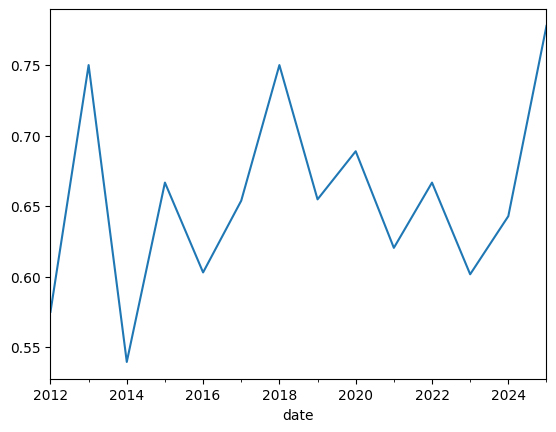

In [12]:
predictions.groupby(pd.Grouper(key='date', freq='Y'))['vote_correct'].mean().plot()

In [13]:
predictions

,vote_id,type,title,drucksache_id,beschlussempfehlung,summary,summary_embedding,date,proposers,party,reasoning,prediction,ground_truth,discipline,category,is_governing,bundestag,vote_correct,is_own_proposal,manifesto_context
0,0,Gesetzentwurf,Gesetzentwurf der Fraktionen der SPD und CDU/C...,20/15096,None,"Abgestimmt wird über eine Grundgesetzänderung,...","[-0.00992498267441988, 0.019715214148163795, 0...",2025-03-18,"[SPD, Union]",AfD,stimmt nicht zu \nBegründung: Der Antrag sieh...,False,False,1.000000,Defense & Security,False,20,True,False,- Arbeitslosenversicherung reformieren: Anspru...
2,2,Gesetzentwurf,Gesetzentwurf der Fraktion der FDP Entwurf ein...,20/15099,None,Im Bundestag wird über die Erweiterung des bes...,"[0.014410934410989285, 0.03800387308001518, 0....",2025-03-18,[FDP],AfD,enthält sich \nBegründung: Das Wahlprogramm e...,False,False,1.000000,Defense & Security,False,20,True,False,- Innere Sicherheit stärken: Bundespolizei per...
3,3,Gesetzentwurf,Gesetzentwurf der Fraktion der CDU/CSU Entwurf...,20/12804,None,Das Gesetz stellt die Begrenzung der Zuwanderu...,"[0.03507666289806366, 0.08015237003564835, 0.0...",2025-01-31,[Union],AfD,stimmt zu \nBegründung: Der Antrag zur Begren...,True,True,1.000000,Internal Affairs & Migration,False,20,True,False,- Rückführungsoffensive: Ausreisepflichtige ko...
4,10,Gesetzentwurf,"Gesetzentwurf der Fraktionen SPD, CDU/CSU, BÜN...",20/12977,None,Im Bundestag wird über eine Verfassungsänderun...,"[-0.01373820099979639, 0.024543749168515205, 0...",2024-12-19,"[SPD, Union, DIE_GRÜNEN, FDP]",AfD,stimmt zu \nBegründung: Das Wahlprogramm beto...,True,False,0.982456,Justice & Consumer Protection,False,20,False,False,- Demokratie und Rechtsstaat\n - Einführung v...
5,17,Gesetzentwurf,"Gesetzentwurf der Fraktionen SPD, BÜNDNIS 90/D...",20/12806,None,"Der Gesetzentwurf zielt darauf ab, die Terrori...","[-0.007711812853813171, 0.020280731841921806, ...",2024-10-18,"[SPD, DIE_GRÜNEN, FDP]",AfD,stimmt zu \nBegründung: Der Antrag zur Stärku...,True,False,1.000000,Digitalization & Modernization,False,20,False,False,- Innere Sicherheit\n - Konsequente Bekämpfun...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,303,Gesetzentwurf,Gesetzentwurf der Bundesregierung,19/14103,Annahme,Es wird über eine schrittweise Rückführung des...,"[0.019990859553217888, -0.0031184873078018427,...",2019-11-14,[Bundesregierung],Union,stimmt zu\nBegründung: Das Wahlprogramm der Pa...,True,True,1.000000,Labor & Social Affairs,True,19,True,True,- Abschaffung des Solidaritätszuschlags schrit...
3302,303,Gesetzentwurf,"Gesetzentwurf der Abgeordneten Christian Dürr,...",19/14286,Ablehnung,"Im Bundestag wird darüber abgestimmt, das Soli...","[0.013860349543392658, 0.00022564873506780714,...",2019-11-14,[FDP],Union,stimmt zu \nBegründung: Das Wahlprogramm der ...,True,False,1.000000,Finance,True,19,False,False,- Abschaffung des Solidaritätszuschlags schrit...
3306,314,Gesetzentwurf,Gesetzentwurf der Abgeordneten Christian Kühn ...,19/8827,Ablehnung,"Es wird darüber abgestimmt, die Umlagefähigkei...","[-0.020645294338464737, 0.04964518919587135, 0...",2019-10-18,[DIE_GRÜNEN],Union,stimmt nicht zu \nBegründung: Der Antrag zur ...,False,False,1.000000,Finance,True,19,True,False,- Abschaffung des Solidaritätszuschlags schrit...
3421,629,Gesetzentwurf,Gesetzentwurf der Fraktionen BÜNDNIS 90/DIE GR...,18/380,Ablehnung,Im Bundestag wird über einen Gesetzentwurf abg...,"[-0.0014615601394325495, 0.02150341309607029, ...",2014-04-03,"[DIE_GRÜNEN, DIE_LINKE]",Union,enthält sich \nDas Wahlprogramm enthält keine...,False,False,1.000000,Justice & Consumer Protection,True,18,True,False,- **Wirtschaft und Innovationsförderung:**\n ...
